In [24]:
# libraries importation
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch
from tensorflow import keras

In [25]:
# # comment this block to run on a local machine
# from google.colab import drive
# drive.mount('/content/gdrive/')
# %cd "/content/gdrive/MyDrive/McGill/ECSE 552 Deep Learning/HW1"

In [26]:
seed = 4256

## Training and validation data generation

In [27]:
nb_train = 1_000 # number of training samples
nb_val = 500 # number of validation samples
p_train_y0 = .5 # proportion of y = 0 training samples
p_val_y0 = .5 # proportion of y = 0 validation samples
nb_train_y0 = int(p_train_y0 * nb_train) # number of training samples with y = 0
nb_val_y0 = int(p_val_y0 * nb_val) # number of validation samples with y = 0
rgn = np.random.default_rng(seed=seed) # pseudo-random number generator

input_y0 = lambda r, t: (r * np.cos(t), r * np.sin(t))
input_y1 = lambda r, t: ((r + 5) * np.cos(t), (r + 5) * np.sin(t))

x_train = np.empty((2, nb_train))
y_train = np.empty((nb_train))
x_val = np.empty((2, nb_val))
y_val = np.empty((nb_val))
r_train, t_train = rgn.normal(0, 1, nb_train), rgn.uniform(0, 2 * np.pi, nb_train)
r_val, t_val = rgn.normal(0, 1, nb_val), rgn.uniform(0, 2 * np.pi, nb_val)
x_train[:, :nb_train_y0] = input_y0(r_train[:nb_train_y0], t_train[:nb_train_y0])
x_train[:, nb_train_y0:] = input_y1(r_train[nb_train_y0:], t_train[nb_train_y0:])
y_train[:nb_train_y0] = 0
y_train[nb_train_y0:] = 1
x_val[:, :nb_val_y0] = input_y0(r_val[:nb_val_y0], t_val[:nb_val_y0])
x_val[:, nb_val_y0:] = input_y1(r_val[nb_val_y0:], t_val[nb_val_y0:])
y_val[:nb_val_y0] = 0
y_val[nb_val_y0:] = 1

# data permutation
shuffled_id_train = rgn.permutation(nb_train)
shuffled_id_val = rgn.permutation(nb_val)
x_train = x_train[:, shuffled_id_train]
x_train = x_train.T
y_train = y_train[shuffled_id_train]
y_train = keras.utils.to_categorical(y_train)

x_val = x_val[:, shuffled_id_val]
x_val = x_val.T
y_val = y_val[shuffled_id_val]
y_val = keras.utils.to_categorical(y_val)


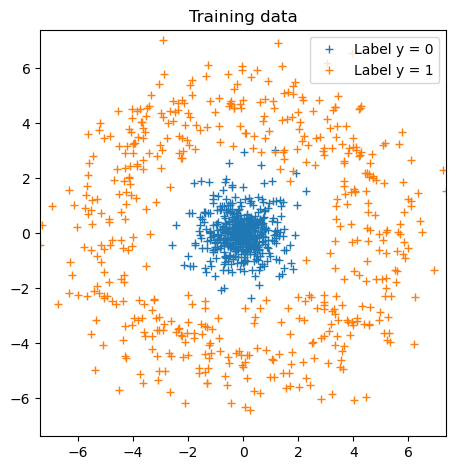

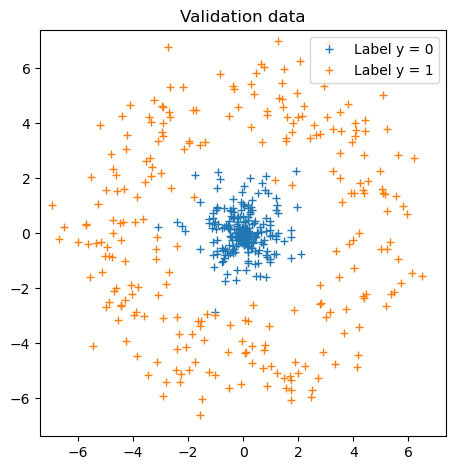

In [28]:
# data visualisation
x_max = np.max([np.abs(x_train).max(), np.abs(x_val).max()])
fig_data, ax_data = plt.subplots()
ax_data.plot(x_train[:, 0][y_train[:, 0] == 1], x_train[:, 1][y_train[:, 0] == 1], color='C0', label="Label y = 0", marker='+', linestyle='')
ax_data.plot(x_train[:, 0][y_train[:, 1] == 1], x_train[:, 1][y_train[:, 1] == 1], color='C1', label="Label y = 1", marker='+', linestyle='')
ax_data.set_xlim(-x_max, x_max)
ax_data.set_ylim(-x_max, x_max)
ax_data.set_aspect('equal')
ax_data.legend()
ax_data.set_title("Training data")
fig_data.tight_layout()
fig_data.savefig('Task_2_TrainData.png', dpi=300, format='png')

fig_data, ax_data = plt.subplots()
plt.rcParams['figure.dpi'] = 100    #S.S: Added these to the graphs to increase the resolution
plt.rcParams['savefig.dpi'] = 300
ax_data.plot(x_val[:, 0][y_val[:, 0] == 1], x_val[:, 1][y_val[:, 0] == 1], color='C0', label="Label y = 0", marker='+', linestyle='')
ax_data.plot(x_val[:, 0][y_val[:, 1] == 1], x_val[:, 1][y_val[:, 1] == 1], color='C1', label="Label y = 1", marker='+', linestyle='')
ax_data.set_xlim(-x_max, x_max)
ax_data.set_ylim(-x_max, x_max)
ax_data.set_aspect('equal')
ax_data.legend()
ax_data.set_title("Validation data")
fig_data.tight_layout()
fig_data.savefig('Task_2_ValidData.png', dpi=300, format='png')

## MLP with PyTorch (with autograd)

In [29]:
torch.manual_seed(seed)

x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
x_valid = torch.tensor(x_val, dtype=torch.float32)
y_valid = torch.tensor(y_val, dtype=torch.float32)

n_train, n_feat = x_train.shape
n_out = 1
n_hidden_1 = 30
print("x_train", x_train, "y_train", y_train)
print("n_train", n_train, "n_feat",  n_feat)
print("y_train max", y_train.min(), "y_train min", y_train.max())

x_train tensor([[ 0.5848, -0.6116],
        [-1.5368,  1.9087],
        [-0.1265, -1.2863],
        ...,
        [-0.8277,  3.3193],
        [-0.3768, -0.1817],
        [ 2.1479,  4.9663]]) y_train tensor([[1., 0.],
        [1., 0.],
        [1., 0.],
        ...,
        [0., 1.],
        [1., 0.],
        [0., 1.]])
n_train 1000 n_feat 2
y_train max tensor(0.) y_train min tensor(1.)


In [30]:
batch_size = 64
lr = .05
epochs = 2_500

In [31]:
def crossentropy(input, target):
  return (- target * input.log() - (1 - target) * torch.log(1 - input)).mean()

loss_func = torch.nn.functional.binary_cross_entropy

In [32]:
def accuracy(input, target):
  pred = (input > .5).float()
  return (pred == target).float().mean()

In [33]:
loss_func = torch.nn.functional.binary_cross_entropy_with_logits

In [34]:
class LogisticRegression(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.lin1 = torch.nn.Linear(n_feat, n_hidden_1)
    self.lin2 = torch.nn.Linear(n_hidden_1, n_out)
    self.activation_func = torch.nn.ReLU()

  def forward(self, x):
    x = self.lin1(x)
    x = self.activation_func(x)
    x = self.lin2(x)
    return x

In [35]:
# add validation data set
x_train.requires_grad_(True)
x_valid

data_train = torch.utils.data.TensorDataset(x_train, y_train[:, 1].reshape(-1, 1))
load_train = torch.utils.data.DataLoader(data_train, batch_size=batch_size)

data_valid = torch.utils.data.TensorDataset(x_valid, y_valid[:, 1].reshape(-1, 1))
load_valid = torch.utils.data.DataLoader(data_valid, batch_size=2 * batch_size) # batch size is twice for validation

In [36]:
def get_model():
  model = LogisticRegression()
  return model, torch.optim.SGD(model.parameters(), lr=lr)

In [37]:
def loss_batch(model, loss_func, xb, yb, opt=None):
  y_pred = model(xb)
  loss = loss_func(y_pred, yb)
  y_pred = (y_pred > .5).float()
  accuracy = (y_pred == yb).float().sum()
  
  if opt is not None:
    loss.backward()
    opt.step()
    opt.zero_grad()

  return accuracy.item(), loss.item(), len(xb)

In [38]:
def fit(epochs, model, loss_func, opt, load_train, load_valid):
  train_loss = []
  valid_loss = []
  train_accuracy = []
  valid_accuracy = []
  models = []
    

  for epoch in range(epochs):
    model.train()

    accuracy = 0.
    loss_weighted = 0.
    nb_samples = 0

    for xb, yb in load_train:
      batch_accuracy, batch_loss, b_size = loss_batch(model, loss_func, xb, yb, opt)
      accuracy += batch_accuracy
      loss_weighted += batch_loss * b_size
      nb_samples += b_size
    
    train_accuracy.append(accuracy / nb_samples)
    train_loss.append(loss_weighted / nb_samples)
    models.append(model)

    model.eval()
    with torch.no_grad():
      accuracies, losses, b_sizes = zip(
          *[loss_batch(model, loss_func, xb, yb, None) for xb, yb in load_valid]
      )
    
    loss_valid = np.sum(np.multiply(losses, b_sizes)) / np.sum(b_sizes)
    accuracy_valid = np.sum(accuracies) / np.sum(b_sizes)
    valid_accuracy.append(accuracy_valid)
    valid_loss.append(loss_valid)
    # print("epoch", epoch, "loss_valid", loss_valid)
  
  return train_accuracy, valid_accuracy, train_loss, valid_loss, models

In [39]:
def get_data(data_train, data_valid, batch_size):
  return (
      torch.utils.data.DataLoader(data_train, batch_size=batch_size, shuffle=True),
      torch.utils.data.DataLoader(data_valid, batch_size=batch_size),
  )

In [40]:
load_train, load_valid = get_data(data_train, data_valid, batch_size)
model, opt = get_model()
train_accuracy, valid_accuracy, train_loss, valid_loss, models = fit(epochs, model, loss_func, opt, load_train, load_valid)

### Find the minimal validation loss

In [41]:
period = 18
for epoch in range(0, epochs - period):
  p = 0
  for i in range(1, period + 1):
    loss = valid_loss[epoch]
    if valid_loss[epoch + i] > loss:
      p += 1
  
  if p >= period:
    print("batch size", batch_size, "learning rate", lr,
          "\nbreak epoch", epoch, "\nminimal validation loss", valid_loss[epoch],
          "\ntraining loss", train_loss[epoch],
          "\nvalidation accuracy", valid_accuracy[epoch],
          "\ntraining accuracy", train_accuracy[epoch])
    break

epoch_overfit = epoch

batch size 64 learning rate 0.05 
break epoch 206 
minimal validation loss 0.03601660829782486 
training loss 0.01960365253686905 
validation accuracy 0.986 
training accuracy 0.995


### Plot training and validation loss

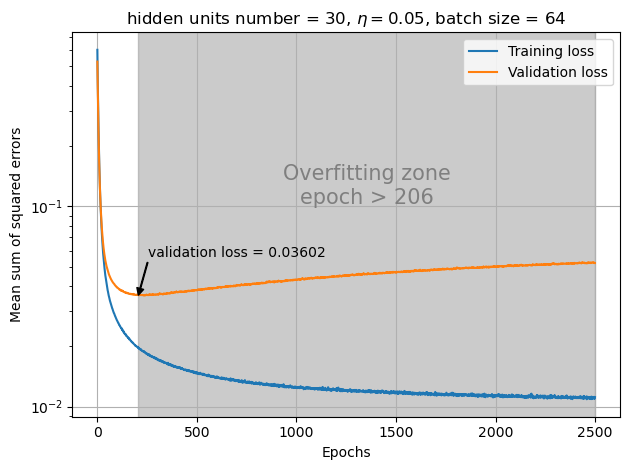

In [42]:
fig, ax = plt.subplots()

plt.rcParams['figure.dpi'] = 100   #S.S: Added these to the graphs to increase the resolution
plt.rcParams['savefig.dpi'] = 300

ax.semilogy(np.arange(epochs), train_loss, color='C0', label="Training loss",
            marker='', linestyle='solid')
ax.semilogy(np.arange(epochs), valid_loss, color='C1', label="Validation loss",
            marker='', linestyle='solid')
x_text, y_text = (epoch_overfit + epochs) / 2, .6
ax.text(x_text, y_text, 'Overfitting zone\nepoch > ' + str(epoch_overfit),
        verticalalignment='center', horizontalalignment='center',
        transform=ax.get_xaxis_transform(),
        color='C7', fontsize=15)
ax.axvspan(epoch_overfit, epochs, color='C7', alpha=.4)
ax.annotate("validation loss = " + str(round(valid_loss[epoch_overfit], 5)),
            xy=(epoch_overfit, valid_loss[epoch_overfit]),
            xytext=(epoch_overfit + 50, valid_loss[epoch_overfit] + 0.02),
            arrowprops=dict(facecolor='black', width=.5, headwidth=5, headlength=5))
ax.grid()
ax.set_xlabel("Epochs")
ax.set_ylabel("Mean sum of squared errors")
ax.legend()
ax.set_title("hidden units number = " + str(n_hidden_1) + r", $\eta = " + str(lr) + r"$, batch size = " + str(batch_size))
fig.tight_layout()
fig.savefig('Task_2_loss_nh' + str(n_hidden_1) + "_bs" + str(batch_size) +'_lr' + str(lr) + '.png',
            dpi=300, format='png')

### Plot training and validation binary classification accuracy

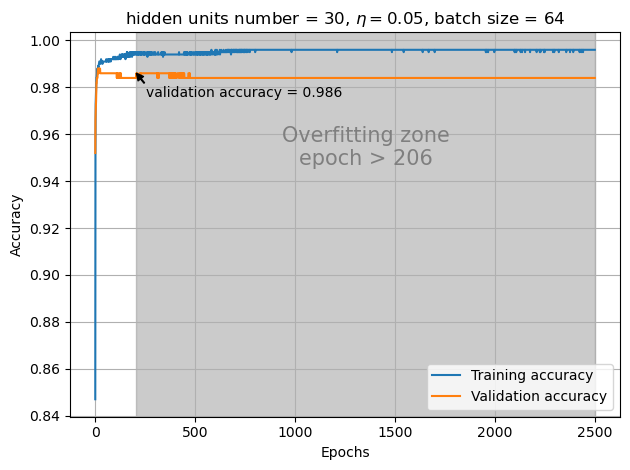

In [43]:
fig, ax = plt.subplots()

plt.rcParams['savefig.dpi'] = 300

ax.plot(np.arange(epochs), train_accuracy, color='C0', label="Training accuracy",
            marker='', linestyle='solid')
ax.plot(np.arange(epochs), valid_accuracy, color='C1', label="Validation accuracy",
            marker='', linestyle='solid')
x_text, y_text = (epoch_overfit + epochs) / 2, .7
ax.text(x_text, y_text, 'Overfitting zone\nepoch > ' + str(epoch_overfit),
        verticalalignment='center', horizontalalignment='center',
        transform=ax.get_xaxis_transform(),
        color='C7', fontsize=15)
ax.axvspan(epoch_overfit, epochs, color='C7', alpha=.4)
ax.annotate("validation accuracy = " + str(round(valid_accuracy[epoch_overfit], 4)),
            xy=(epoch_overfit, valid_accuracy[epoch_overfit]),
            xytext=(epoch_overfit + 50, valid_accuracy[epoch_overfit] - 0.01),
            arrowprops=dict(facecolor='black', width=.5, headwidth=5, headlength=5))
ax.grid()
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")
ax.legend()
ax.set_title("hidden units number = " + str(n_hidden_1) + r", $\eta = " + str(lr) + r"$, batch size = " + str(batch_size))
fig.tight_layout()
fig.savefig('Task_2_accuracy_nh' + str(n_hidden_1) + "_bs" + str(batch_size) +'_lr' + str(lr) + '.png',
            dpi=300, format='png')

### Activation boundaries

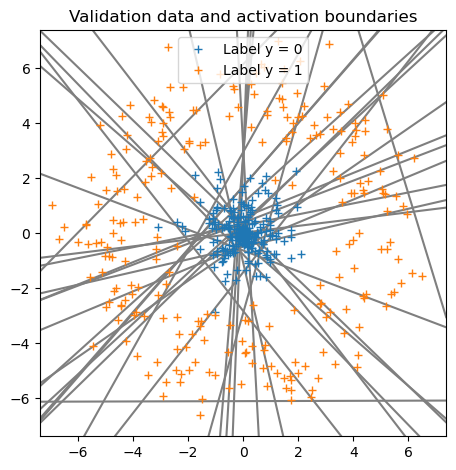

In [44]:
# hidden units decision boundaries
weights = models[epoch_overfit].lin1.weight.detach().numpy() # shape (n_hidden_1, n_feat)
biases = models[epoch_overfit].lin1.bias.detach().numpy() # shape (n_hidden_1)
n_bound = 1_000
b = biases.copy()
biases = np.resize(b, (n_bound, n_hidden_1)).T
bound_x1 = np.linspace(-x_max, x_max, n_bound)
bound_x2 = np.einsum('j,i->ij', bound_x1, weights[:, 0]) + biases
bound_x2 = np.einsum('ij,i->ij', bound_x2, -1 / weights[:, 1])
fig_bound, ax_bound = plt.subplots()
for i in range(bound_x2.shape[0]):
  ax_bound.plot(bound_x1, bound_x2[i], color='C7')
ax_bound.plot(x_val[:, 0][y_val[:, 0] == 1], x_val[:, 1][y_val[:, 0] == 1], color='C0', label="Label y = 0", marker='+', linestyle='')
ax_bound.plot(x_val[:, 0][y_val[:, 1] == 1], x_val[:, 1][y_val[:, 1] == 1], color='C1', label="Label y = 1", marker='+', linestyle='')
ax_bound.set_xlim(-x_max, x_max)
ax_bound.set_ylim(-x_max, x_max)
ax_bound.set_aspect('equal')
ax_bound.set_title("Validation data and activation boundaries")
ax_bound.legend()
fig_bound.tight_layout()
fig_bound.savefig('Task_2_bound.png', dpi=300, format='png')

### Decision boundaries

In [45]:
weights = models[epoch_overfit].lin1.weight.detach().numpy() # shape (n_hidden_1, n_feat)
biases = models[epoch_overfit].lin1.bias.detach().numpy() # shape (n_hidden_1)
n_bound = 1_000
b = biases.copy()
biases = np.resize(b, (n_bound, n_bound, n_hidden_1)).T
bound_x1 = np.linspace(-x_max, x_max, n_bound)
bound_x2 = np.linspace(-x_max, x_max, n_bound)
X1, X2 = np.meshgrid(bound_x1, bound_x2)
bound_x1x2 = np.stack([X1, X2], axis=2)
bound_x1x2 = torch.from_numpy(bound_x1x2).type(torch.float)
y_pred = model(bound_x1x2)
decision_boundary = (y_pred > .5).squeeze()

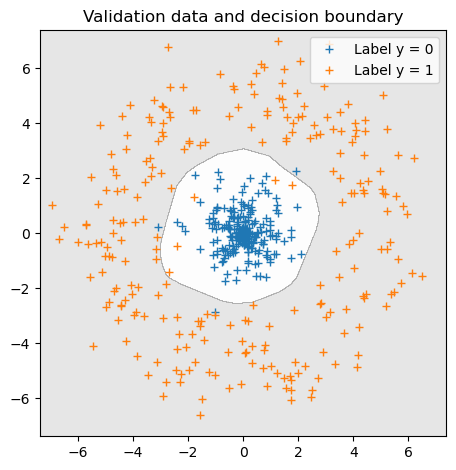

In [46]:
fig_dbound, ax_dbound = plt.subplots()
ax_dbound.contourf(X1, X2, decision_boundary, cmap='binary', alpha=.1)
ax_dbound.plot(x_val[:, 0][y_val[:, 0] == 1], x_val[:, 1][y_val[:, 0] == 1], color='C0', label="Label y = 0", marker='+', linestyle='')
ax_dbound.plot(x_val[:, 0][y_val[:, 1] == 1], x_val[:, 1][y_val[:, 1] == 1], color='C1', label="Label y = 1", marker='+', linestyle='')
ax_dbound.set_xlim(-x_max, x_max)
ax_dbound.set_ylim(-x_max, x_max)
ax_dbound.set_aspect('equal')
ax_dbound.set_title("Validation data and decision boundary")
ax_dbound.legend()
fig_dbound.tight_layout()
fig_dbound.savefig('Task_2_DecisionBound.png', dpi=300, format='png')